# 823 Individual Assignment 2

- [Jessica, Sun]
- [20095990]
- [2025,02,14]

# Part One: Historical Data and Stock Betas Analysis
##### Data collection

In [1]:
# I am using Yahoo Finance to pull out the Stock data and using 3-Month Treasury Bill: Constant Maturity Rate as risk free rate 
# https://fred.stlouisfed.org
import yfinance as yf
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# Define tickers and date range
tickers = ["RACE", "TSLA", "JNJ", "XOM", "^GSPC"]
start_date = "2015-01-02"
end_date = "2025-01-02"

#Collect historical weekly price data for stocks and S&P 500 index
data = yf.download(tickers, start=start_date, end=end_date, interval="1wk")['Close']#I am using Closed price since there is no column of Adj Close through python

# Calculate weekly returns
returns = data.pct_change().dropna()

#Collect historical 3-month Treasury Bill rates (DGS3MO)
# DGS3MO: Daily 3-Month Treasury Bill Constant Maturity Rate
risk_free_daily = pdr.get_data_fred('DGS3MO', start=start_date, end=end_date)
risk_free_daily.head()


[*********************100%***********************]  5 of 5 completed


,DGS3MO
DATE,
2015-01-02,0.02
2015-01-05,0.03
2015-01-06,0.03
2015-01-07,0.03
2015-01-08,0.03


In [2]:
# Convert annualized rates to weekly and align with returns data
risk_free_daily = risk_free_daily / 100
risk_free_weekly = risk_free_daily.resample('W-FRI').last()  # Resample to weekly frequency
risk_free_weekly = risk_free_weekly.reindex(returns.index, method='ffill')  # Align with returns



In [3]:
risk_free_weekly.head()

,DGS3MO
Date,
2015-10-22,0.0001
2015-10-26,0.0001
2015-10-29,0.0001
2015-11-02,0.0008
2015-11-05,0.0008


##### Beta Estimation

In [4]:
# Subtract risk-free rate to calculate excess returns
excess_returns = returns.subtract(risk_free_weekly['DGS3MO'], axis=0)
market_excess_returns = excess_returns["^GSPC"]

# Beta Estimation (OLS Regression)
results = {}
for stock in tickers[:-1]:  # Exclude the market index (^GSPC)
    model = sm.OLS(excess_returns[stock], sm.add_constant(market_excess_returns)).fit()
    results[stock] = model
    print(f"Beta Estimation for {stock}:")
    print(model.summary())
    print("\n")



Beta Estimation for RACE:
                            OLS Regression Results                            
Dep. Variable:                   RACE   R-squared:                       0.183
Model:                            OLS   Adj. R-squared:                  0.182
Method:                 Least Squares   F-statistic:                     214.3
Date:                Fri, 14 Feb 2025   Prob (F-statistic):           6.13e-44
Time:                        15:21:23   Log-Likelihood:                 1984.0
No. Observations:                 960   AIC:                            -3964.
Df Residuals:                     958   BIC:                            -3954.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0065     

##### Explanation
In CAPM model, Beta compares a security or portfolio's volatility or systematic risk to the market. In our case, I choose S&P 500 Index (GSPC) as market. If the absolute value of Beta between 0-1, means the stock has low sensitive, and if beta equals to 1 means the price of a security moves with the market. If Beta greater than 1, means the price is more sensitive to market price.

* RACE: Beta=0.5777, means the price of Ferrari is relatively stable. For example if market price rise 1 buck then RACE price will approximately rise 0.57 buck.
* TESLA: Beta=1.445, means the price of Tesla has a high seneitivity to the market price. If market goes up 1, and tesla will approximately rise 1.445. Conversely, tesla will decrease 1.445
* JNJ: Beta=0.7828, similar to  RACE but more sensitive, if market price change with 1, JNJ will change with 0.78
* XOM: Beta=1.0087, has almost same rate with market price, means that its returns move almost one-to-one with the market.


All of the p-value in this case are less than 0.05, means all the beta are significant.
TESLA is the most seneitive to the market change and RACE is the least.

##### Moving Window Regression

In [5]:

# Start with 3-year window (157 weeks) from 2015-10-22
# In this case RACE didnt have any data before 2015.10.19, then i used 10-22 as the start

start_date = "2015-10-22"
window_size = 157  # Approximately 3 years
moving_betas = {stock: [] for stock in tickers[:-1]}  # Exclude market index (^GSPC)
dates = []



In [6]:
# Inspect available dates in the index
print("Available dates in returns index:")
print(returns.index)

Available dates in returns index:
DatetimeIndex(['2015-10-22', '2015-10-26', '2015-10-29', '2015-11-02',
               '2015-11-05', '2015-11-09', '2015-11-12', '2015-11-16',
               '2015-11-19', '2015-11-23',
               ...
               '2024-11-28', '2024-12-02', '2024-12-05', '2024-12-09',
               '2024-12-12', '2024-12-16', '2024-12-19', '2024-12-23',
               '2024-12-26', '2024-12-30'],
              dtype='datetime64[ns]', name='Date', length=960, freq=None)


In [7]:
# Perform moving window regression
print("Beta values for each stock over time:\n")
start_index = returns.index.get_loc(start_date)  # Get the index of the start date

for i in range(start_index, len(returns) - window_size + 1):
    window_returns = excess_returns.iloc[i:i + window_size]
    market_window = market_excess_returns.iloc[i:i + window_size]
    current_date = returns.index[i + window_size - 1]  # End date of the window
    dates.append(current_date)

    print(f"Window ending on {current_date}:")
    for stock in tickers[:-1]:  # Exclude market index
        model = sm.OLS(window_returns[stock], sm.add_constant(market_window)).fit()
        beta_value = model.params[1]
        moving_betas[stock].append(beta_value)  # Store beta value
        print(f"  {stock}: Beta = {beta_value:.4f}")
    print("\n")



Beta values for each stock over time:

Window ending on 2017-04-20 00:00:00:
  RACE: Beta = -0.0579
  TSLA: Beta = 1.8471
  JNJ: Beta = 0.7015
  XOM: Beta = 0.8130


Window ending on 2017-04-24 00:00:00:
  RACE: Beta = -0.0826
  TSLA: Beta = 1.9689
  JNJ: Beta = 0.6927
  XOM: Beta = 0.8174


Window ending on 2017-04-27 00:00:00:
  RACE: Beta = -0.0646
  TSLA: Beta = 1.9683
  JNJ: Beta = 0.6938
  XOM: Beta = 0.8129


Window ending on 2017-05-01 00:00:00:
  RACE: Beta = -0.0950
  TSLA: Beta = 1.9324
  JNJ: Beta = 0.6893
  XOM: Beta = 0.7929


Window ending on 2017-05-04 00:00:00:
  RACE: Beta = -0.0995
  TSLA: Beta = 1.9321
  JNJ: Beta = 0.6895
  XOM: Beta = 0.7930


Window ending on 2017-05-08 00:00:00:
  RACE: Beta = -0.1043
  TSLA: Beta = 1.9097
  JNJ: Beta = 0.6957
  XOM: Beta = 0.7681


Window ending on 2017-05-11 00:00:00:
  RACE: Beta = -0.0867
  TSLA: Beta = 1.9391
  JNJ: Beta = 0.6403
  XOM: Beta = 0.7370


Window ending on 2017-05-15 00:00:00:
  RACE: Beta = -0.0806
  TSLA: Bet

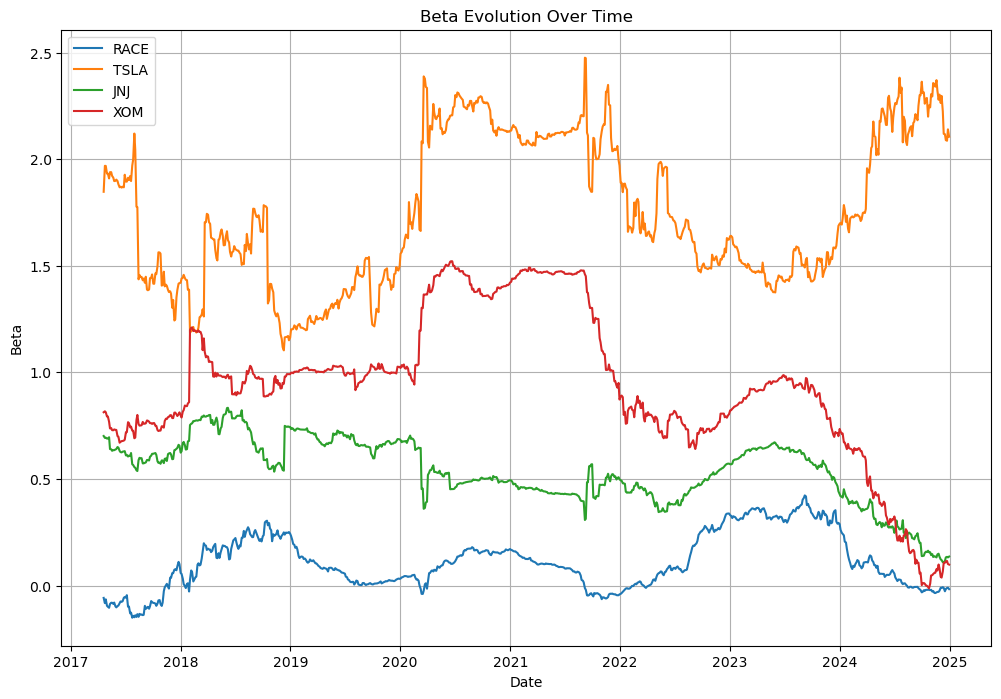


Full Beta DataFrame:
                RACE      TSLA       JNJ       XOM
2017-04-20 -0.057927  1.847074  0.701511  0.812959
2017-04-24 -0.082551  1.968922  0.692689  0.817350
2017-04-27 -0.064625  1.968283  0.693817  0.812894
2017-05-01 -0.094983  1.932436  0.689329  0.792873
2017-05-04 -0.099457  1.932109  0.689529  0.793013
...              ...       ...       ...       ...
2024-12-16 -0.026815  2.117431  0.114778  0.106857
2024-12-19 -0.016557  2.089512  0.132138  0.113249
2024-12-23 -0.011327  2.086582  0.134579  0.115366
2024-12-26 -0.010143  2.139962  0.131931  0.100938
2024-12-30 -0.016687  2.105523  0.136010  0.098196

[804 rows x 4 columns]


In [8]:
# Convert moving_betas to a DataFrame for easier plotting
moving_betas_df = pd.DataFrame(moving_betas, index=dates)

# Plotting the beta values over time
plt.figure(figsize=(12, 8))
for stock in tickers[:-1]:  # Exclude market index
    plt.plot(moving_betas_df.index, moving_betas_df[stock], label=stock)

plt.title("Beta Evolution Over Time")
plt.xlabel("Date")
plt.ylabel("Beta")
plt.legend()
plt.grid()
plt.show()

# Optionally, print the full DataFrame for review
print("\nFull Beta DataFrame:")
print(moving_betas_df)


# Part Two: Logit Regression for Credit Default
##### 2.1 Apply the Logit regression and follow the specific instructions.

In [9]:
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
import seaborn as sns

In [10]:
#Upload data file

df = 'Credit Card Data.xlsx'  
credit_data = pd.ExcelFile(df)
data = credit_data.parse('Credit Card Data')
data.head
data.info()#Print info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   SEX                         30000 non-null  int64
 3   EDUCATION                   30000 non-null  int64
 4   MARRIAGE                    30000 non-null  int64
 5   AGE                         30000 non-null  int64
 6   PAY_0                       30000 non-null  int64
 7   PAY_2                       30000 non-null  int64
 8   PAY_3                       30000 non-null  int64
 9   PAY_4                       30000 non-null  int64
 10  PAY_5                       30000 non-null  int64
 11  PAY_6                       30000 non-null  int64
 12  BILL_AMT1                   30000 non-null  int64
 13  BILL_AMT2                   30000 non-null  int64
 14  BILL_A

In [11]:
# After checking the data, SEX, Education, Marrige need to be changed to dummies

from sklearn.preprocessing import OrdinalEncoder
data = pd.get_dummies(data, columns=['SEX', 'EDUCATION', 'MARRIAGE','PAY_0','PAY_2','PAY_3','PAY_4','PAY_5','PAY_6'], drop_first=True)


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   ID                          30000 non-null  int64
 1   LIMIT_BAL                   30000 non-null  int64
 2   AGE                         30000 non-null  int64
 3   BILL_AMT1                   30000 non-null  int64
 4   BILL_AMT2                   30000 non-null  int64
 5   BILL_AMT3                   30000 non-null  int64
 6   BILL_AMT4                   30000 non-null  int64
 7   BILL_AMT5                   30000 non-null  int64
 8   BILL_AMT6                   30000 non-null  int64
 9   PAY_AMT1                    30000 non-null  int64
 10  PAY_AMT2                    30000 non-null  int64
 11  PAY_AMT3                    30000 non-null  int64
 12  PAY_AMT4                    30000 non-null  int64
 13  PAY_AMT5                    30000 non-null  int64
 14  PAY_AM

In [13]:
eda_summary = data.describe()
# Checking for missing values
missing_values = data.isnull().sum()
print("Missing Values in Dataset:\n", missing_values)



Missing Values in Dataset:
 ID           0
LIMIT_BAL    0
AGE          0
BILL_AMT1    0
BILL_AMT2    0
            ..
PAY_6_4      0
PAY_6_5      0
PAY_6_6      0
PAY_6_7      0
PAY_6_8      0
Length: 84, dtype: int64


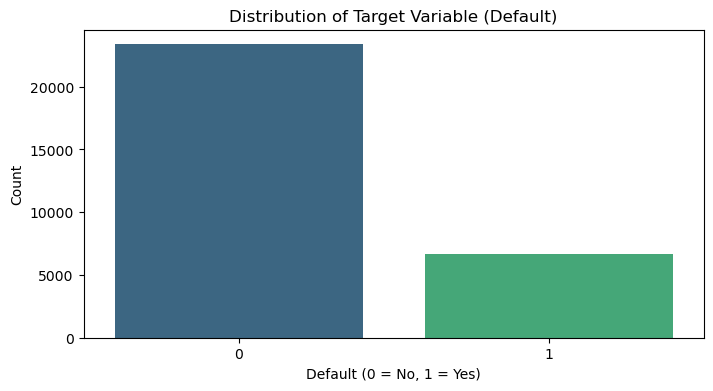

In [14]:
# Distribution of the target variable
plt.figure(figsize=(8, 4))
sns.countplot(x='default.payment.next.month', data=data, palette='viridis')
plt.title('Distribution of Target Variable (Default)')
plt.xlabel('Default (0 = No, 1 = Yes)')
plt.ylabel('Count')
plt.show()



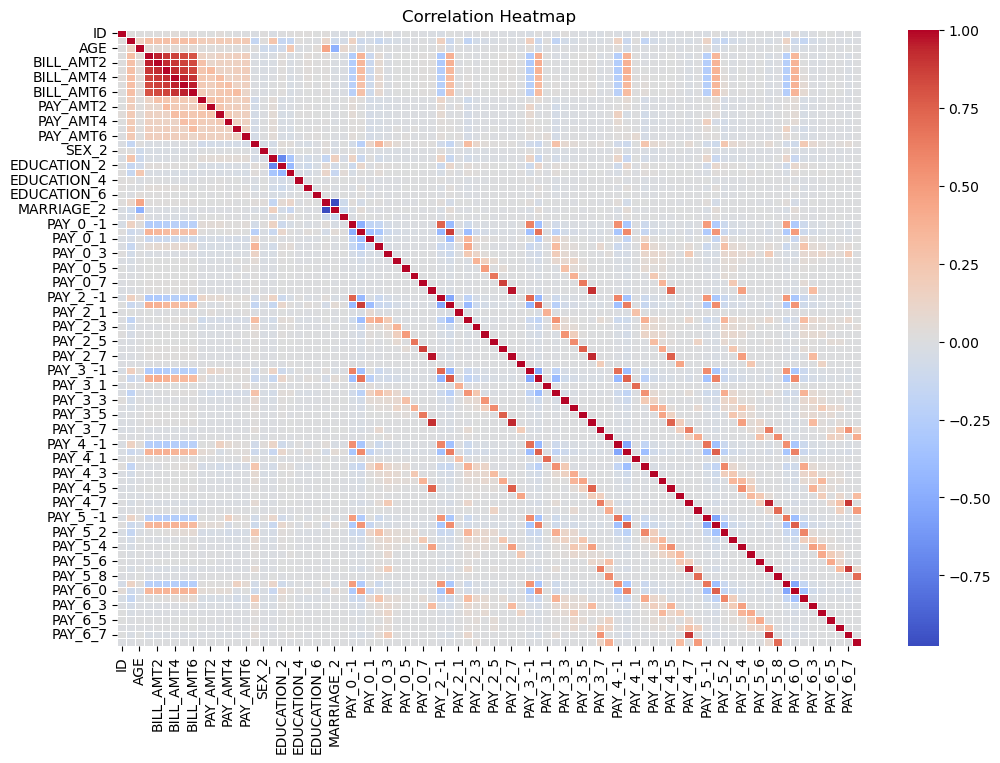

In [15]:
# Correlation heatmap
plt.figure(figsize=(12, 8))
correlation_matrix = data.corr()
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()
# This heatmap shows the dataset is not balance


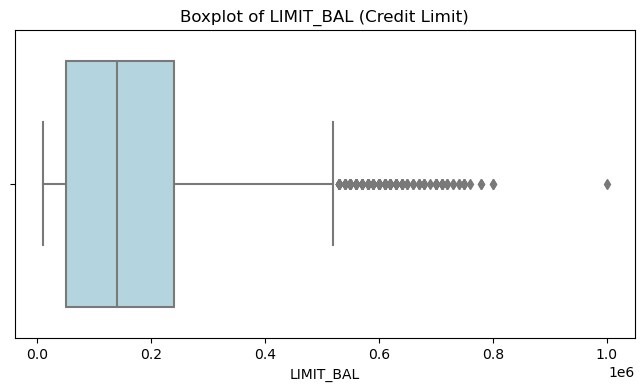

In [16]:
# Boxplot for LIMIT_BAL (Credit Limit)
plt.figure(figsize=(8, 4))
sns.boxplot(x=data['LIMIT_BAL'], color='lightblue')
plt.title('Boxplot of LIMIT_BAL (Credit Limit)')
plt.xlabel('LIMIT_BAL')
plt.show()
#has outliers

In [17]:

# Summary statistics
print("Summary Statistics of the Dataset:\n", eda_summary)

Summary Statistics of the Dataset:
                  ID       LIMIT_BAL           AGE      BILL_AMT1  \
count  30000.000000    30000.000000  30000.000000   30000.000000   
mean   15000.500000   167484.322667     35.485500   51223.330900   
std     8660.398374   129747.661567      9.217904   73635.860576   
min        1.000000    10000.000000     21.000000 -165580.000000   
25%     7500.750000    50000.000000     28.000000    3558.750000   
50%    15000.500000   140000.000000     34.000000   22381.500000   
75%    22500.250000   240000.000000     41.000000   67091.000000   
max    30000.000000  1000000.000000     79.000000  964511.000000   

           BILL_AMT2     BILL_AMT3      BILL_AMT4      BILL_AMT5  \
count   30000.000000  3.000000e+04   30000.000000   30000.000000   
mean    49179.075167  4.701315e+04   43262.948967   40311.400967   
std     71173.768783  6.934939e+04   64332.856134   60797.155770   
min    -69777.000000 -1.572640e+05 -170000.000000  -81334.000000   
25%      29

In [18]:
# Delet outliers at the 95th percentile for payment and bill amounts
numeric_columns = ['LIMIT_BAL'] + [col for col in data.columns if 'BILL_AMT' in col or 'PAY_AMT' in col]
cap_values = data[numeric_columns].quantile(0.95)
for col in numeric_columns:
    data[col] = data[col].clip(upper=cap_values[col])



In [19]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 84 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  int64  
 2   AGE                         30000 non-null  int64  
 3   BILL_AMT1                   30000 non-null  float64
 4   BILL_AMT2                   30000 non-null  float64
 5   BILL_AMT3                   30000 non-null  float64
 6   BILL_AMT4                   30000 non-null  float64
 7   BILL_AMT5                   30000 non-null  float64
 8   BILL_AMT6                   30000 non-null  int64  
 9   PAY_AMT1                    30000 non-null  float64
 10  PAY_AMT2                    30000 non-null  float64
 11  PAY_AMT3                    30000 non-null  float64
 12  PAY_AMT4                    30000 non-null  float64
 13  PAY_AMT5                    300

In [20]:
# Normalize numerical variables
scaler = MinMaxScaler()
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])

In [21]:
# Split data into training (first 20000 rows) and testing (next 10000 rows)
train_data = data.iloc[:20000, :]
test_data = data.iloc[20000:, :]
X_train = train_data.drop(columns=['ID', 'default.payment.next.month'])
y_train = train_data['default.payment.next.month']
X_test = test_data.drop(columns=['ID', 'default.payment.next.month'])
y_test = test_data['default.payment.next.month']

In [22]:

# Train Logistic Regression Model
logit_model = LogisticRegression(max_iter=1000, random_state=42)
logit_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [23]:
# Predict and Evaluate
y_pred = logit_model.predict(X_test)
y_pred_proba = logit_model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)
classification_rep = classification_report(y_test, y_pred)

# Feature Importance
feature_importance = pd.Series(logit_model.coef_[0], index=X_train.columns).sort_values(ascending=False)
# Results
print("Model Accuracy:", accuracy)
print("ROC AUC Score:", roc_auc)
print("\nClassification Report:\n", classification_rep)


Model Accuracy: 0.8354
ROC AUC Score: 0.7752459373501845

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.96      0.90      7922
           1       0.72      0.34      0.47      2078

    accuracy                           0.84     10000
   macro avg       0.78      0.65      0.68     10000
weighted avg       0.82      0.84      0.81     10000



In [24]:
top_10_features = feature_importance.abs().nlargest(10).index  # Get top 10 based on absolute value
df_top_10 = pd.DataFrame({'Feature': top_10_features, 'Coefficient': feature_importance[top_10_features].values})

# Display the DataFrame
print(df_top_10)

       Feature  Coefficient
0      PAY_0_3     1.887878
1      PAY_0_2     1.863930
2      PAY_0_4     1.455772
3   MARRIAGE_1     1.101141
4      PAY_0_5     1.088775
5   MARRIAGE_3     1.078303
6      PAY_2_6     1.012340
7   MARRIAGE_2     0.950931
8      PAY_2_4    -0.926795
9  EDUCATION_4    -0.774959


<Figure size 1000x600 with 0 Axes>

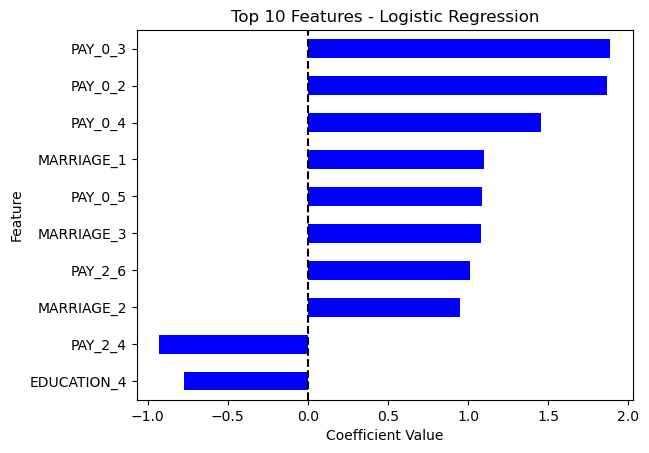

In [25]:
plt.figure(figsize=(10, 6))
df_top_10.set_index('Feature').plot(kind='barh', legend=False, color=df_top_10['Coefficient'].apply(lambda x: 'red' if x < 0 else 'blue'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Features - Logistic Regression')
plt.axvline(x=0, color='black', linestyle='--')  # Vertical line at 0 to separate positive & negative
plt.gca().invert_yaxis()
plt.show()


##### 2.2 Repeat (2.1) with a different Train-Test sample

In [26]:
# New train-test split: last 20000 rows for training, first 10000 rows for testing
train_data_new = data.iloc[10000:, :]
test_data_new = data.iloc[:10000, :]

# Separate features and target variable
X_train_new = train_data_new.drop(columns=['ID', 'default.payment.next.month'])
y_train_new = train_data_new['default.payment.next.month']
X_test_new = test_data_new.drop(columns=['ID', 'default.payment.next.month'])
y_test_new = test_data_new['default.payment.next.month']

# Train the logistic regression model with the new split
logit_model_new = LogisticRegression(max_iter=1000, random_state=42)
logit_model_new.fit(X_train_new, y_train_new)

# Predict and evaluate
y_pred_new = logit_model_new.predict(X_test_new)
y_pred_proba_new = logit_model_new.predict_proba(X_test_new)[:, 1]
accuracy_new = accuracy_score(y_test_new, y_pred_new)
roc_auc_new = roc_auc_score(y_test_new, y_pred_proba_new)
classification_rep_new = classification_report(y_test_new, y_pred_new)

# Feature importance for the new model
feature_importance_new = pd.Series(logit_model_new.coef_[0], index=X_train_new.columns).sort_values(ascending=False)

# Results
print("New Model Accuracy:", accuracy_new)
print("New ROC AUC Score:", roc_auc_new)
print("\nClassification Report:\n", classification_rep_new)

New Model Accuracy: 0.8057
New ROC AUC Score: 0.7544449939980852

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.95      0.88      7741
           1       0.64      0.33      0.43      2259

    accuracy                           0.81     10000
   macro avg       0.73      0.64      0.66     10000
weighted avg       0.78      0.81      0.78     10000



In [27]:
top_10_features_new = feature_importance_new.abs().nlargest(10).index  # Get top 10 based on absolute value
df_top_10_new= pd.DataFrame({'Feature': top_10_features_new, 'Coefficient': feature_importance_new[top_10_features_new].values})

# Display the DataFrame
print(df_top_10_new)

       Feature  Coefficient
0      PAY_0_2     1.731533
1      PAY_0_3     1.685785
2      PAY_2_7     0.885391
3  EDUCATION_5    -0.879141
4   MARRIAGE_3     0.860592
5    BILL_AMT3     0.852365
6      PAY_3_7     0.818931
7      PAY_6_3     0.808901
8      PAY_6_6     0.800848
9      PAY_4_5    -0.765127


<Figure size 1000x600 with 0 Axes>

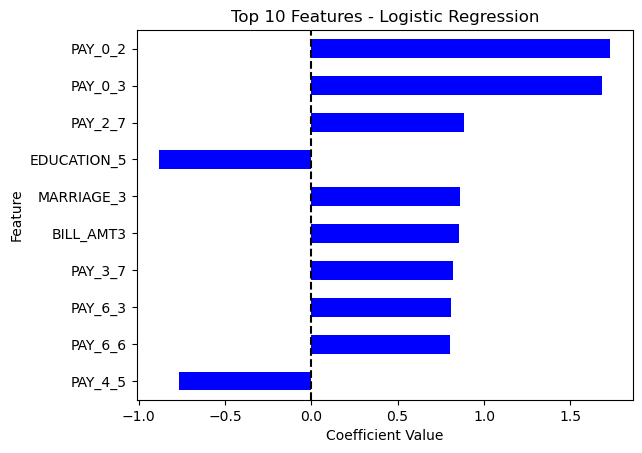

In [28]:
plt.figure(figsize=(10, 6))
df_top_10_new.set_index('Feature').plot(kind='barh', legend=False, color=df_top_10['Coefficient'].apply(lambda x: 'red' if x < 0 else 'blue'))
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.title('Top 10 Features - Logistic Regression')
plt.axvline(x=0, color='black', linestyle='--')  # Vertical line at 0 to separate positive & negative
plt.gca().invert_yaxis()
plt.show()

##### Explanation

* Two results don't have big difference, when I use first 20000 rows as train set, Model Accuracy is 0.8354 and ROC AUC Score is 0.7752. If I change the train set to last 20000 rows, New Model Accuracy is 0.8057 and New ROC AUC Score is  0.7544.

* Although the orders are differnt, the first ten of most important features are the similar that the repayment status delay over 2 months will be easier to get deafult payment.



# Part Three: Yield curve data

In [29]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

data3 = pd.read_csv("/Users/ka/Downloads/yield_curves.csv")

data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Columns: 122 entries, Date to  
dtypes: object(122)
memory usage: 2.4+ MB


In [30]:
data3['Date'] = pd.to_datetime(data3['Date'])
data3.iloc[:, 1:] = data3.iloc[:, 1:].apply(pd.to_numeric, errors='coerce')
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2588 entries, 0 to 2587
Columns: 122 entries, Date to  
dtypes: datetime64[ns](1), object(121)
memory usage: 2.4+ MB


In [31]:
# Yield curve comparison
latest_date = data3['Date'].max()
end_of_2023 = pd.Timestamp('2023-12-31')

latest_data_row = data3[data3['Date'] == latest_date].iloc[:, 1:]
data_dec_2023_rows = data3[(data3['Date'] >= '2023-12-01') & (data3['Date'] <= '2023-12-31')].iloc[:, 1:]

# Check if data exists for the required dates
if latest_data_row.empty or data_dec_2023_rows.empty:
    raise ValueError("Data for the latest date or December 2023 is missing.")

# Convert data to numeric for plotting
latest_data = latest_data_row.values.flatten()
data_dec_2023 = data_dec_2023_rows.mean().values.flatten()

# Extract maturities from column names
maturities = [col.replace('ZC', '').replace('YR', '') for col in data3.columns[1:]]

# Ensure all dimensions match for plotting
if len(maturities) != len(latest_data) or len(maturities) != len(data_dec_2023):
    raise ValueError("Mismatch in dimensions between maturities and yield data.")

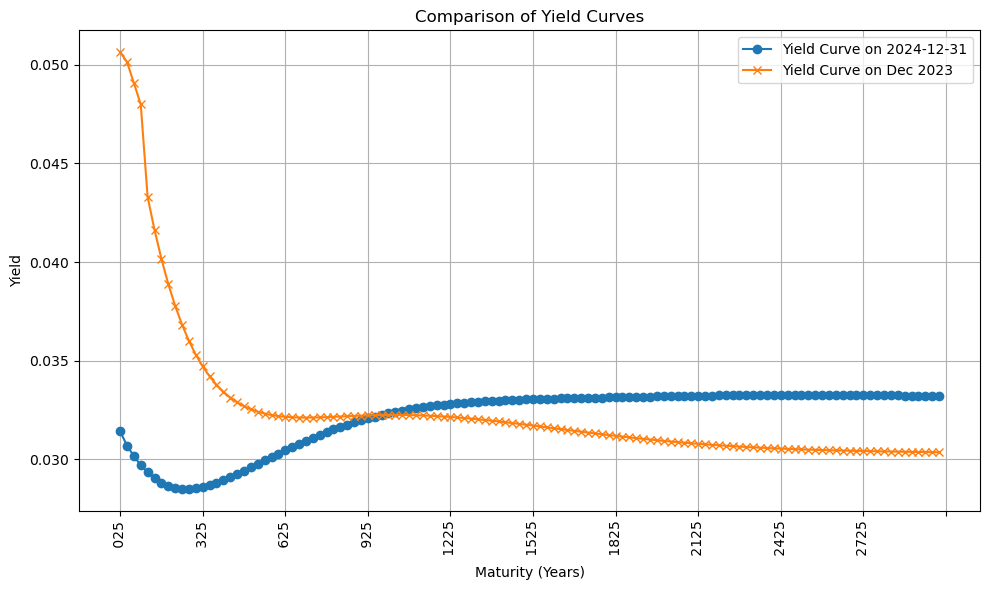

In [32]:
# Plot the yield curves
plt.figure(figsize=(10, 6))
plt.plot(maturities, latest_data, label=f'Yield Curve on {latest_date.date()}', marker='o')
plt.plot(maturities, data_dec_2023, label='Yield Curve on Dec 2023', marker='x')

# Update x-ticks to display only key years (e.g., every 300 years)
step = max(1, len(maturities) // 10)  # Adjust spacing dynamically
plt.xticks(
    ticks=range(0, len(maturities), step),
    labels=[f'{maturity}' for maturity in maturities[::step]],
    rotation=90  # Slight rotation for better readability
)

plt.xlabel('Maturity (Years)')
plt.ylabel('Yield')
plt.title('Comparison of Yield Curves')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [33]:
valid_columns = data3.columns[1:][data3.iloc[:, 1:].notna().mean() > 0.9]
filtered_data = data3[valid_columns].dropna()

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data)


##### Explanation

* From the curves of 2023 and 2024, we can see that during the short term(0-6.25), interest rate of 2024 is lower than 2023, and for the Medium-Term Yields (6.25-15.25) both curves are close to each other, and for the Long-Tear Yields (15.25+),the blue curve stays above the orange one in a flat rate. Means for the long-term market will not have significant flactuate. The inversion between yield curves geteing small means the difference between short-term and long-term yield has narrowed.
* The short-term yield downward rapidly means the rate cuts happened, the long-term yield of 2024 kept slightly above might because of the inflation.

In [34]:
#Do PCA
pca = PCA()
pca_data = pca.fit_transform(scaled_data)

# Calculate the number of components explaining 99% of variance
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio.cumsum()
components_99_var = (cumulative_variance < 0.99).sum() + 1

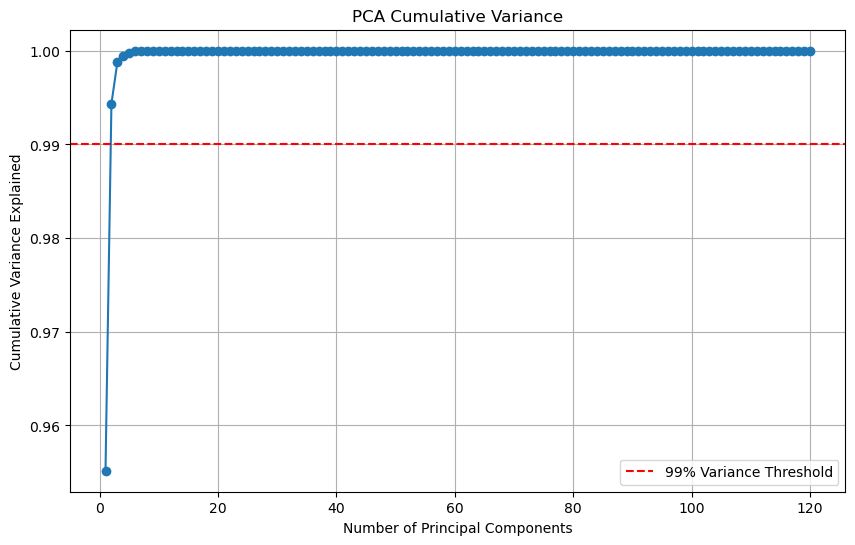

Number of components explaining 99% of variance: 2


In [35]:
# Plot cumulative variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.axhline(0.99, color='r', linestyle='--', label='99% Variance Threshold')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('PCA Cumulative Variance')
plt.legend()
plt.grid()
plt.show()


# Output the number of components explaining 99% of variance
print(f"Number of components explaining 99% of variance: {components_99_var}")


In [36]:
 # Get PCA component loadings (weights of original features in PCA)
pca_components = pca.components_[:components_99_var]  # Use only components explaining 99% variance

# Create a DataFrame for component loadings with maturities as index
pca_loadings = pd.DataFrame(pca_components.T, index=filtered_data.columns, columns=[f'PCA{i+1}' for i in range(components_99_var)])

# Sort the top absolute contributors for each principal component
top_pca_features = {
    f'PCA{i+1}': pca_loadings[f'PCA{i+1}'].abs().sort_values(ascending=False).head(10)
    for i in range(min(2, components_99_var))  # Get top features for first two components
}

# Display explained variance
print("Explained Variance Ratio:")
print(pd.DataFrame({"Component": [f'PCA{i+1}' for i in range(components_99_var)], "Explained Variance": explained_variance_ratio[:components_99_var]}))

# Display top features contributing to PCA components
for component, features in top_pca_features.items():
    print(f"Top Features Contributing to {component}:")
    print(features)




Explained Variance Ratio:
  Component  Explained Variance
0      PCA1            0.955163
1      PCA2            0.039176
Top Features Contributing to PCA1:
 ZC1250YR    0.093262
 ZC1275YR    0.093261
 ZC1225YR    0.093257
 ZC1300YR    0.093253
 ZC1200YR    0.093244
 ZC1325YR    0.093239
 ZC1175YR    0.093225
 ZC1350YR    0.093219
 ZC1150YR    0.093197
 ZC1375YR    0.093194
Name: PCA1, dtype: float64
Top Features Contributing to PCA2:
 ZC100YR    0.171341
 ZC175YR    0.170312
 ZC200YR    0.170177
 ZC150YR    0.169809
 ZC225YR    0.169430
 ZC075YR    0.168912
 ZC125YR    0.168657
 ZC250YR    0.168104
 ZC275YR    0.166238
 ZC050YR    0.165808
Name: PCA2, dtype: float64


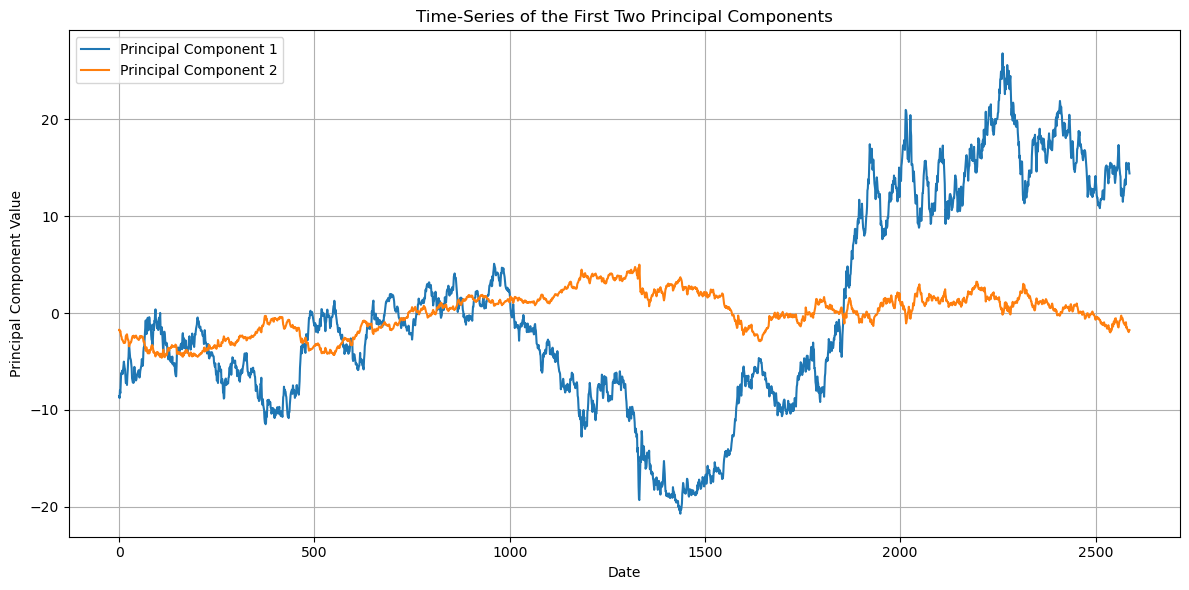

In [37]:


# Prepare data for plotting principal components
pca_df = pd.DataFrame({
    'Date': filtered_data.index,  # Ensure dates match the filtered rows
    'PC1': pca_data[:, 0],
    'PC2': pca_data[:, 1]
}).reset_index(drop=True)
# Plot the first two principal components over time
plt.figure(figsize=(12, 6))
plt.plot(pca_df['Date'], pca_df['PC1'], label='Principal Component 1')
plt.plot(pca_df['Date'], pca_df['PC2'], label='Principal Component 2')
plt.xlabel('Date')
plt.ylabel('Principal Component Value')
plt.title('Time-Series of the First Two Principal Components')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()